In [1]:
import kagglehub
import os

path = kagglehub.dataset_download('rohitgrewal/airlines-flights-data')
print('Path berada di :', path)
print('Isi Path tersebut adalah', os.listdir(path))

Using Colab cache for faster access to the 'airlines-flights-data' dataset.
Path berada di : /kaggle/input/airlines-flights-data
Isi Path tersebut adalah ['airlines_flights_data.csv']


In [2]:
import pandas as pd

df = pd.read_csv(path + '/airlines_flights_data.csv')
df

,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


**PREPROCESSING**

In [3]:
df.drop(columns='index',inplace=True)
df.head(5)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [4]:
Features = ['source_city', 'departure_time','stops','arrival_time','destination_city','class','days_left']

In [5]:
X = df[Features]
y = df['price']

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
print(f"Jumlah data training :{len(X_train)} dan jumlah data uji :{len(X_test)}")

Jumlah data training :240122 dan jumlah data uji :60031


In [11]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

scaler = StandardScaler()
num_feat = ['days_left']
num_transform = scaler

In [12]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_feat = ['source_city','departure_time','stops','arrival_time','destination_city']
cat_transform = encoder

In [13]:
ordinal_feat = ['class']
class_categ = ['Economy','Business']
ordinalt_transform = OrdinalEncoder(categories=[class_categ])

In [14]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np

log_transform = FunctionTransformer(np.log1p, inverse_func=np.expm1)

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('log',log_transform),
        ('scaler', num_transform)
    ]), num_feat),
    ('ord', ordinalt_transform, ordinal_feat),
    ('cat', cat_transform, cat_feat)
], remainder='drop')

In [17]:
from lightgbm import LGBMRegressor

lbgm = LGBMRegressor(random_state=42)

In [18]:
from sklearn.compose import TransformedTargetRegressor

model_lbgm = TransformedTargetRegressor(
    regressor = lbgm,
    func = np.log1p,
    inverse_func= np.expm1
)

In [19]:
lbgm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model_lbgm)
])

**HYPERPARAMETER TUNING**

In [24]:
params_grid = {
    'regressor__regressor__n_estimators' : [200, 300, 500],
    'regressor__regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__regressor__max_depth' : [10, 15, 20]
}

In [25]:
from sklearn.model_selection import GridSearchCV

gridsearchLBGM = GridSearchCV(
    estimator= lbgm_pipeline,
    param_grid= params_grid,
    cv = 5,
    scoring='r2',
    n_jobs=-1,
    verbose =2
)

In [26]:
gridsearchLBGM.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106
[LightGBM] [Info] Number of data points in the train set: 240122, number of used features: 29
[LightGBM] [Info] Start training from score 9.330749


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                              inverse_func=<ufunc 'expm1'>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['days_left']),
                                                                        ('ord',
                                                                         OrdinalEncoder(categories=[['Economy',
                                                                                                     'Business']]),
                                                                         ['class']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore...
                                                                          'destination_city'])])),
                                       ('regressor',
                                        TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                                   inverse_func=<ufunc 'expm1'>,
                                                                   regressor=LGBMRegressor(random_state=42)))]),
             n_jobs=-1,
             param_grid={'regressor__regressor__learning_rate': [0.05, 0.1,
                                                                 0.2],
                         'regressor__regressor__max_depth': [10, 15, 20],
                         'regressor__regressor__n_estimators': [200, 300, 500]},
             scoring='r2', verbose=2)

In [27]:
best_LGBM = gridsearchLBGM.best_estimator_

In [31]:
print(type(X_test))
print(X_test.columns)

<class 'pandas.core.frame.DataFrame'>
Index(['source_city', 'departure_time', 'stops', 'arrival_time',
       'destination_city', 'class', 'days_left'],
      dtype='object')


**EVALUTE**

In [28]:
print('Best params yang ditemukan :', gridsearchLBGM.best_params_)
print('Best Score CV yang ditemukan :', gridsearchLBGM.best_score_)

Best params yang ditemukan : {'regressor__regressor__learning_rate': 0.2, 'regressor__regressor__max_depth': 20, 'regressor__regressor__n_estimators': 500}
Best Score CV yang ditemukan : 0.9547424489203079


In [29]:
print(best_LGBM)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['days_left']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['Economy',
                                                                              'Business']]),
                                                  ['class']),
                                                 ('cat',
                   

In [33]:
y_pred = best_LGBM.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)

print('=== Hasil Evaluasi Model Dengan Data Uji ===')
print(f'Best R2 Score yang ditemukan adalah {R2}')
print(f'Best MAE yang ditemukan adalah {MAE:.4f}')
print(f'Best RMSE yang ditemukan adalah {RMSE:.4f}')

=== Hasil Evaluasi Model Dengan Data Uji ===
Best R2 Score yang ditemukan adalah 0.9541565156648573
Best MAE yang ditemukan adalah 2809.0199
Best RMSE yang ditemukan adalah 4861.2245


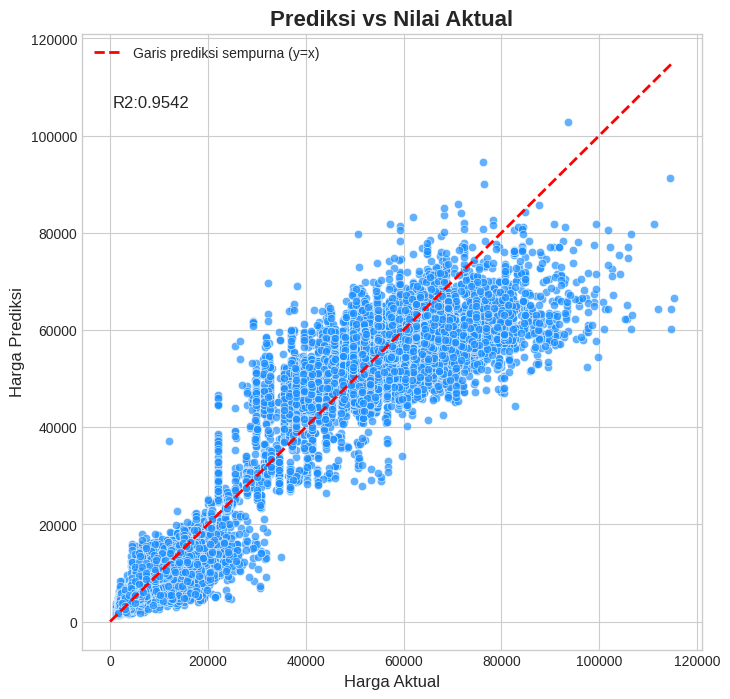

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

seaborn_version = 'seaborn-v0_8-whitegrid'

plt.figure(figsize=(8,8))
plt.style.use(seaborn_version)

sns.scatterplot(x=y_test, y=y_pred, color = 'dodgerblue', alpha=0.7)
max_val = max(y_test.max(), y_pred.max())
y_pred.max()

plt.plot([0, max_val],[0, max_val], 'r--', lw=2, label='Garis prediksi sempurna (y=x)')
plt.title('Prediksi vs Nilai Aktual', fontsize=16, fontweight='bold')
plt.xlabel('Harga Aktual', fontsize=12)
plt.ylabel('Harga Prediksi', fontsize=12)
plt.legend()
plt.text(0.05,0.9, f'R2:{R2:.4f}', transform=plt.gca(). transAxes, fontsize=12, verticalalignment='top')
plt.show()

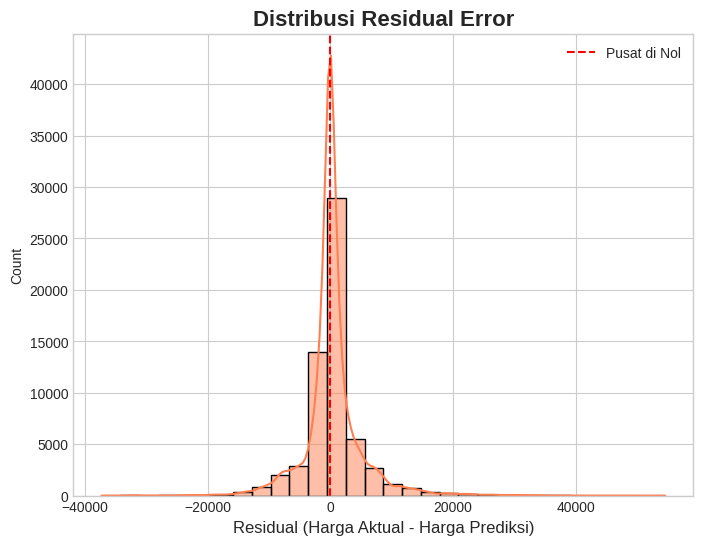

In [38]:
residual = y_test - y_pred

plt.figure(figsize=(8,6))
plt.style.use(seaborn_version)

sns.histplot(residual, kde=True, color='coral', bins=30)
plt.title('Distribusi Residual Error', fontsize=16, fontweight='bold')
plt.xlabel('Residual (Harga Aktual - Harga Prediksi)', fontsize=12)
plt.axvline(0, color='r', linestyle='--', label='Pusat di Nol')
plt.legend()
plt.show()

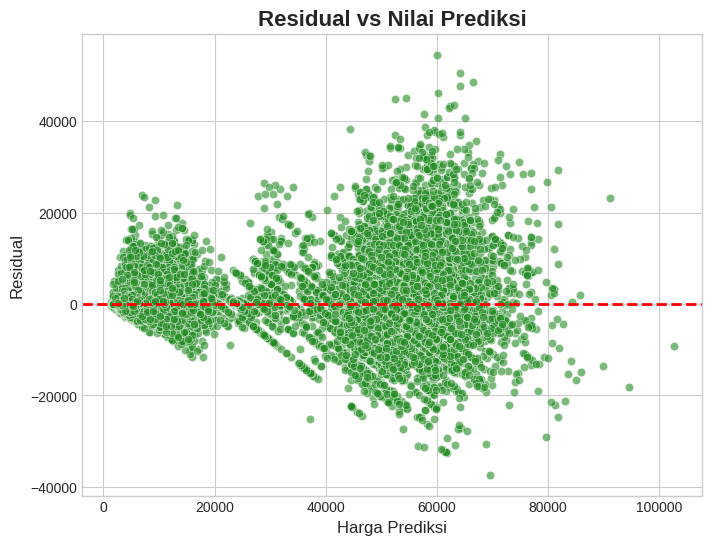

In [39]:
plt.figure(figsize=(8,6))
plt.style.use(seaborn_version)

sns.scatterplot(x=y_pred, y=residual, color='forestgreen', alpha=0.6)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.title('Residual vs Nilai Prediksi', fontsize=16, fontweight='bold')
plt.xlabel('Harga Prediksi', fontsize=12)
plt.ylabel('Residual', fontsize=12)
plt.show()


In [40]:
# Mengambil step preprocessor dan regressor (XGBoost)

preprocessor = best_LGBM.named_steps['preprocessor']
model = best_LGBM.named_steps['regressor'].regressor_

In [41]:
# Ambil fitur numerik
num_features = preprocessor.transformers_[0][2]

# Ambil fitur ordinal
ord_features = preprocessor.transformers_[1][2]

# Ambil fitur kategori (one-hot)
ohe = preprocessor.transformers_[2][1]
cat_features = preprocessor.transformers_[2][2]
ohe_features = list(ohe.get_feature_names_out(cat_features))


# Gabungkan semuanya
all_features = list(num_features) + list(ord_features) + ohe_features


In [42]:
# Feature importance dari model XGBoost
importances = model.feature_importances_

# Buat dataframe
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)


In [43]:
feature_importance_df

,Feature,Importance
0,days_left,2912
1,class,1171
2,stops_one,706
3,source_city_Delhi,496
4,arrival_time_Evening,480
5,arrival_time_Night,479
6,departure_time_Evening,478
7,departure_time_Afternoon,469
8,destination_city_Delhi,459
9,destination_city_Kolkata,445


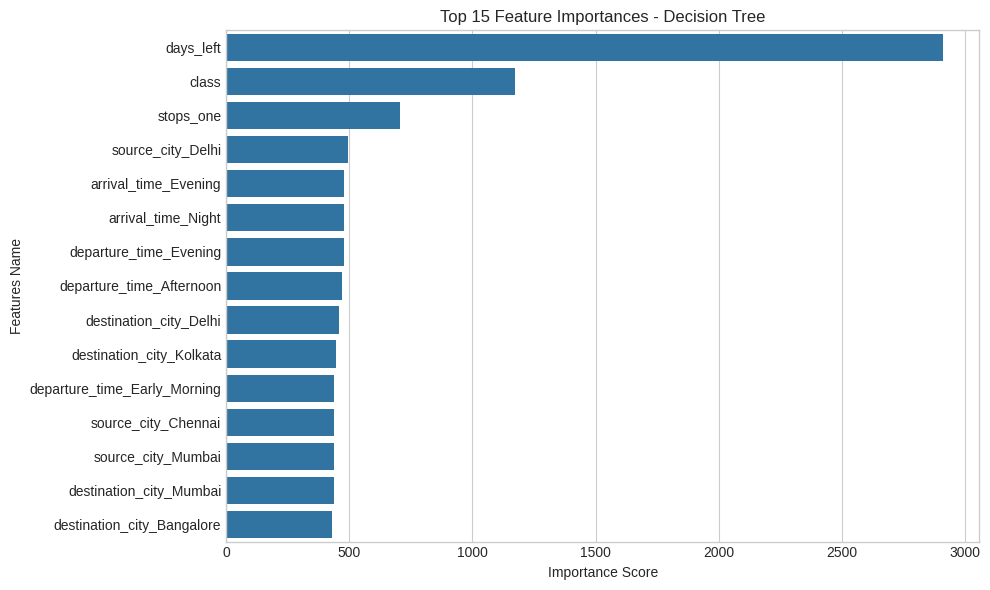

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature')
plt.title('Top 15 Feature Importances - LightGBM')
plt.xlabel('Importance Score')
plt.ylabel('Features Name')
plt.tight_layout()
plt.show()

In [45]:
from google.colab import files
import joblib

joblib.dump(best_LGBM, 'LGBM_Prediction_Ticket_Price.pkl')
files.download('LGBM_Prediction_Ticket_Price.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>